# Solve a RBC model

Last update: Oct 29th, 2020

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
# Parameterization
alpha = 1.0 / 3
beta = 0.96
gamma = 1.0
delta = 0.1

# A very simple z process
n_z = 3
z_grid = np.array([-0.1, 0, 0.1])
P = np.array([[0.8, 0.15, 0.05], [0.1, 0.8, 0.1], [0.05, 0.15, 0.8]])

In [39]:
# Utility function
def u(c, gamma):
    if (c < 0):
        return -1e10
    elif (gamma == 1.0):
        return np.log(c)
    else:
        return (c ** (1 - gamma)) / (1 - gamma)

In [40]:
# Production function
def f(z, k, alpha):
    return np.exp(z) * (k ** alpha)

Up to now are some parameterizations and function definitions. For demonstration, we use the parameters that are consistent with annual calibrations: $\delta = 0.1$ and $\beta = 0.96$. Moreover, we assume the evolution of Total Factor of Productivity.

$$
\begin{align*}
z & =\left[-0.1,0,0.1\right]\\
P & =\left[\begin{array}{ccc}
0.8 & 0.15 & 0.05\\
0.1 & 0.8 & 0.1\\
0.05 & 0.15 & 0.8
\end{array}\right]
\end{align*}
$$

In [56]:
# Make a grid
n_k = 100
k_min = 0.01
k_max = 6.0
k_grid = np.linspace(k_min, k_max, n_k)

In [46]:
%%time

T = 100
V = np.zeros((T, n_z, n_k))
policy = np.zeros((n_z, n_k))

# Loops are slow.
for i in range(T - 1):
    for j in range(n_z):
        for k in range(n_k):
            V[i + 1, j, k] = -1e10
            for kp in range(n_k):
                c = f(z_grid[j], k_grid[k], alpha) - (k_grid[kp] - (1 - delta) * k_grid[k])
                tmp = u(c, gamma) + beta * np.dot(P[j, :], V[i, :, kp])
                if (tmp > V[i + 1, j, k]):
                    V[i + 1, j, k] = tmp
                    policy[j, k] = k_grid[kp]
                    

Wall time: 18.9 s


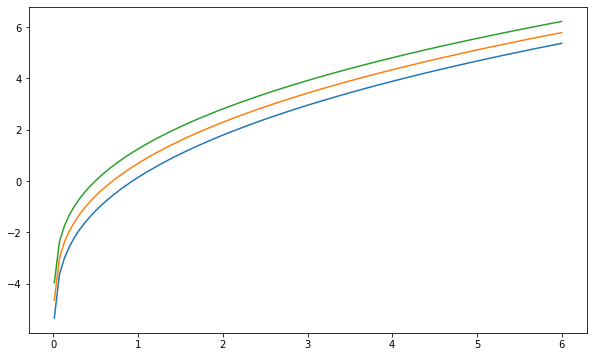

In [47]:
plt.figure(figsize = (10, 6))
plt.plot(k_grid, V[T - 1, :, :].T)
plt.show()

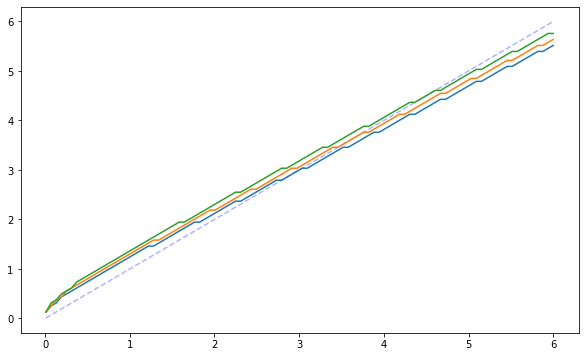

In [49]:
plt.figure(figsize = (10, 6))
plt.plot(k_grid, k_grid, "b--", alpha = 0.3)
plt.plot(k_grid, policy.T)
plt.show()

In [50]:
def u_vec(c, gamma):
    if (gamma == 1.0):
        res = np.log(c)
    else:
        res = (c ** (1 - gamma)) / (1 - gamma)
    
    res[np.isnan(res)] = -1e10
    
    return res

In [51]:
%%time

# Vectorize some operations
T = 1000
V = np.zeros((T, n_z, n_k))
policy = np.zeros((n_z, n_k))

for i in range(T - 1):
    for j in range(n_z):
        for k in range(n_k):
            V[i + 1, j, k] = -1e10
            c_grid = f(z_grid[j], k_grid[k], alpha) + (1 - delta) * k_grid[k] - k_grid
            tmp = u_vec(c_grid, gamma) + beta * np.dot(P[j, :], V[i, :, :])
            V[i + 1, j, k] = np.max(tmp)
            policy[j, k] = k_grid[np.argmax(tmp)]
    
    # Check convergence
    diff = np.max(np.abs(V[i + 1, :, :] - V[i, :, :]))
    if (diff < 1e-4):
        V_converge = V[i, :, :]
        print(f"Converge in {i} iterations")
        break

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Converge in 157 iterations
Wall time: 1.06 s


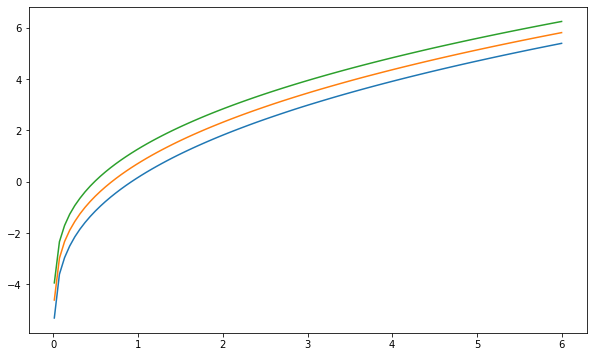

In [52]:
plt.figure(figsize = (10, 6))
plt.plot(k_grid, V_converge.T)
plt.show()

In [73]:
# Scale up a bit?
n_k = 1000
k_grid = np.linspace(k_min, k_max, n_k)

In [78]:
%%time

# Vectorize some operations
T = 100
V = np.zeros((T, n_z, n_k))
policy = np.zeros((n_z, n_k))
consumption = np.zeros((n_z, n_k))
investment = np.zeros((n_z, n_k))

for i in range(T - 1):
    for j in range(n_z):
        for k in range(n_k):
            V[i + 1, j, k] = -1e10
            c_grid = f(z_grid[j], k_grid[k], alpha) + (1 - delta) * k_grid[k] - k_grid
            tmp = u_vec(c_grid, gamma) + beta * np.dot(P[j, :], V[i, :, :])
            V[i + 1, j, k] = np.max(tmp)
            policy[j, k] = k_grid[np.argmax(tmp)]
            consumption[j, k] = f(z_grid[j], k_grid[k], alpha) - (policy[j,k] - (1 - delta) * k_grid[k])
            investment[j, k] = (policy[j, k] - (1 - delta) * k_grid[k])

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Wall time: 17 s


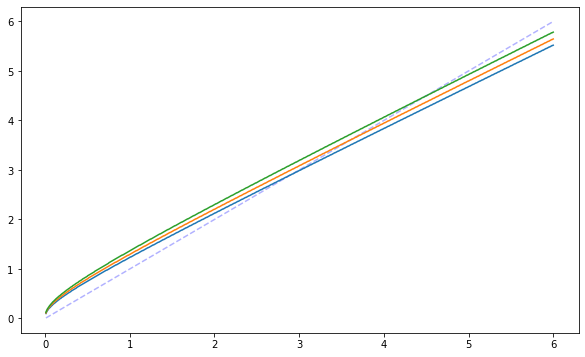

In [75]:
# Policy Function
plt.figure(figsize = (10, 6))
plt.plot(k_grid, k_grid, 'b--', alpha = 0.3)
plt.plot(k_grid, policy.T)
plt.show()

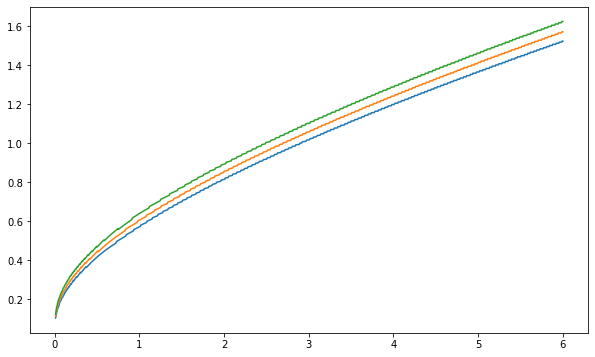

In [76]:
# Consumption
plt.figure(figsize = (10, 6))
plt.plot(k_grid, consumption.T)
plt.show()

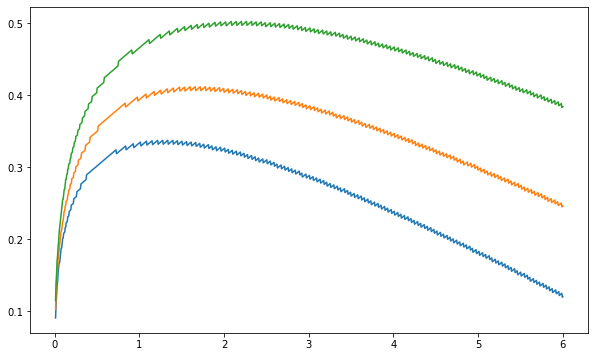

In [79]:
# Investment
plt.figure(figsize = (10, 6))
plt.plot(k_grid, investment.T)
plt.show()

In [70]:
# Try a nonlinear grid?
n_k = 300
k_grid = np.exp(np.linspace(np.log(k_min), np.log(k_max), n_k))

In [71]:
T = 500
V = np.zeros((T, n_z, n_k))
policy = np.zeros((n_z, n_k))

for i in range(T - 1):
    for j in range(n_z):
        for k in range(n_k):
            V[i + 1, j, k] = -1e10
            c_grid = f(z_grid[j], k_grid[k], alpha) + (1 - delta) * k_grid[k] - k_grid
            tmp = u_vec(c_grid, gamma) + beta * np.dot(P[j, :], V[i, :, :])
            V[i + 1, j, k] = np.max(tmp)
            policy[j, k] = k_grid[np.argmax(tmp)]

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


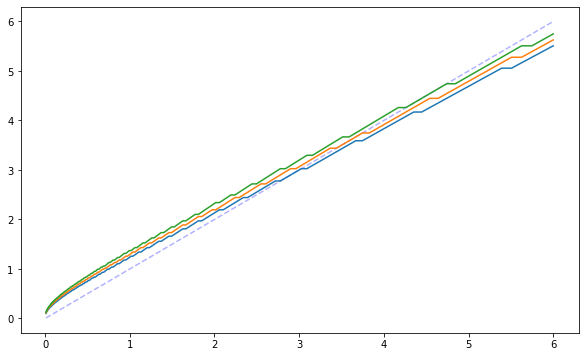

In [72]:
# Policy Function
plt.figure(figsize = (10, 6))
plt.plot(k_grid, k_grid, 'b--', alpha = 0.3)
plt.plot(k_grid, policy.T)
plt.show()